In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from tqdm import tqdm
import scipy.optimize as optimize
import scipy.constants

Λ_cutoff = 5000
Nc = 3
mσ = 500
mq = 300
mπ = 1e-5#140
fπ = 93
n_sat = 0.15 #in units fm^-3

MeV = 1e6 * 1.6e-19
ħ = scipy.constants.hbar
c = scipy.constants.c
fm = 1e-15 

ϕ_lin = np.linspace(1e-5, 300, 2)
Δ_lin = np.linspace(0, 400, 10)

In [2]:
def C(p):
    return np.real(2-2*np.emath.sqrt(4*mq**2/(p**2)-1)*np.arctan(1/(np.emath.sqrt(4*mq**2/(p**2)-1))))

def dC(p):
    return np.real(4*mq**2/(p**4*np.emath.sqrt(4*mq**2/(p**2)-1))*np.arctan(1/(np.emath.sqrt(4*mq**2/(p**2)-1)))-1/(p**2))


def E(p, m):
    return np.sqrt(p**2 + m**2)

def EΔp(p, m, Δ, μ_bar):  
    return np.sqrt((E(p, m) + μ_bar)**2 + Δ**2)

def EΔm(p, m, Δ, μ):
    if Δ == 0:
        return E(p,m)-μ
    else:
        return np.sqrt((E(p, m)-μ)**2 + Δ**2)

def step(x):
    if x >= 0:
        return 1
    else:
        return 0

def Ω_num(ϕ, Δ, μ):
    def integrand(p):
        if Δ == 0:
            return 0
        else:
            return p**2*(EΔp(p, ϕ, Δ, μ) + EΔm(p, ϕ, Δ, μ) - 2*np.sqrt(p**2+ϕ**2+Δ**2) - 2*Δ**2*μ**2/(2*(p**2+ϕ**2+Δ**2)**(3/2))
                    )

    integral, err = integrate.quad(integrand, 0, Λ_cutoff, limit=150)

    return 2*integral/(np.pi**2)

In [3]:
Cσ = C(mσ)
Cπ = C(mπ)
dCπ = dC(mπ)

m0 = np.sqrt((mσ**2-3*mπ**2)/2 + 2*Nc*mq**2/((4*np.pi)**2*fπ**2)*(4*mq**2 + (mσ**2-4*mq**2)*Cσ - mσ**2*Cπ - (mσ**2-3*mπ**2)*mπ**2*dCπ))

λ0 = 3*(mσ**2-mπ**2)/fπ**2 + 12*Nc*mq**2/((4*np.pi)**2*fπ**4)*((mσ**2-4*mq**2)*(Cσ - Cπ - mπ**2*dCπ) + mπ**4*dCπ)

h0 = -mπ**2*fπ**2*(1-4*Nc*mq**2/((4*np.pi)**2*fπ**2)*mπ**2*dCπ)/fπ

m0_tree = -np.sqrt((mσ**2-3*mπ**2)/2)
λ0_tree = 3*(mσ**2-mπ**2)/fπ**2

g0 = mq/fπ
λ3 = λ0
λΔ = λ0/4
mΔ = 600
gΔ = 3/2*g0
print(abs(h0)**(1/3),g0, m0, λ0)
print(m0_tree, λ0_tree)

0.0021029437174614213 3.225806451612903 487.02239546047457 65.80379080308276
-353.55339059327355 86.71522719389522


In [4]:
def Ωϕ(ϕ):
        if ϕ == 0:
            return 0 
        else: 
            return  h0*fπ*ϕ/mq - 1/2*m0**2*fπ**2*ϕ**2/(mq**2) + 1/24*λ0*fπ**4*ϕ**4/(mq**4) + 2*mq**4/((4*np.pi)**2)*(np.log(mq**2/(ϕ**2)) -(Cπ+mπ**2*dCπ))*ϕ**4/(mq**4) + 2*Nc*mq**4/((4*np.pi)**2)*(3/2)*ϕ**4/(mq**4)

def ΩϕΔ(ϕ, Δ, μ):
    if ϕ == 0 and Δ == 0:
        return 0
    if ϕ == 0:
        μ_bar = μ
        return  (mΔ**2-4*μ_bar**2)/(gΔ**2)*Δ**2 - 16/((4*np.pi)**2)*(np.log(mq**2/(Δ**2))-(Cπ+mπ**2*dCπ))*μ_bar**2*Δ**2 + λΔ/(6*gΔ**4)*Δ**4 + 6/((4*np.pi)**2)*Δ**4 + 4/((4*np.pi)**2)*(np.log(mq**2/(Δ**2))-(Cπ + mπ**2*dCπ))*(Δ**4)
    if Δ ==0:
        μ_bar = μ
        return     4*mq**4/((4*np.pi)**2)*(np.log((mq**2)/(ϕ**2)) -(Cπ+mπ**2*dCπ))*ϕ**4/(mq**4)
    else:
        μ_bar = μ 
        return 1/12*λ3*fπ**2/(gΔ**2*mq**2)*Δ**2*ϕ**2 + 12/((4*np.pi)**2)*ϕ**2*Δ**2 + (mΔ**2-4*μ_bar**2)/(gΔ**2)*Δ**2 - 16/((4*np.pi)**2)*(np.log(mq**2/(Δ**2+ϕ**2))-(Cπ+mπ**2*dCπ))*μ_bar**2*Δ**2 + λΔ/(6*gΔ**4)*Δ**4 + 6/((4*np.pi)**2)*Δ**4 + 4/((4*np.pi)**2)*(np.log(mq**2/(Δ**2+ϕ**2))-(Cπ + mπ**2*dCπ))*(Δ**4) +  8/((4*np.pi)**2)*(np.log(mq**2/(Δ**2+ϕ**2))-(Cπ + mπ**2*dCπ))*Δ**2*ϕ**2 + 4*mq**4/((4*np.pi)**2)*(np.log((mq**2)/(ϕ**2+Δ**2)) -(Cπ+mπ**2*dCπ))*ϕ**4/(mq**4)


def ΩTμ(ϕ, Δ, μ, T, Λ):
    
    def integrand(p):
        if Δ != 0:
            return p**2*(np.log(1+np.exp(-(E(p, ϕ) - μ)/T))
                        +np.log(1+np.exp(-(E(p, ϕ) + μ)/T))

                        +np.log(1+np.exp(-(E(p, ϕ) - μ)/T))
                        +np.log(1+np.exp(-(E(p, ϕ) + μ)/T))

                        +2*np.log(1+np.exp(-np.sqrt((E(p, ϕ) - μ)**2 + Δ**2)/T))
                        +2*np.log(1+np.exp(-np.sqrt((E(p, ϕ) - μ)**2 + Δ**2)/T))

                        +2*np.log(1+np.exp(-np.sqrt((E(p, ϕ) + μ)**2 + Δ**2)/T))
                        +2*np.log(1+np.exp(-np.sqrt((E(p, ϕ) + μ)**2 + Δ**2)/T)))
        else:
            return p**2*(np.log(1+np.exp(-(E(p, ϕ) - μ)/T))
                        +np.log(1+np.exp(-(E(p, ϕ) + μ)/T))

                        +np.log(1+np.exp(-(E(p, ϕ) - μ)/T))
                        +np.log(1+np.exp(-(E(p, ϕ) + μ)/T))

                        +2*np.log(1+np.exp(-(E(p, ϕ) - μ)/T))
                        +2*np.log(1+np.exp(-(E(p, ϕ) - μ)/T))

                        +2*np.log(1+np.exp(-(E(p, ϕ) + μ)/T))
                        +2*np.log(1+np.exp(-(E(p, ϕ) + μ)/T)))
       
    integral, err = integrate.quad(integrand, 0, np.inf)
    #Double check the prefactor here!
    return -T*integral/((np.pi)**2)

In [5]:
def Ω_tot(ϕΔ, μ, T):
    ϕ, Δ = ϕΔ
    return Ωϕ(ϕ) + ΩϕΔ(ϕ, Δ, μ) + ΩTμ(ϕ, Δ, μ,T,Λ_cutoff) - Ω_num(ϕ, Δ, μ)

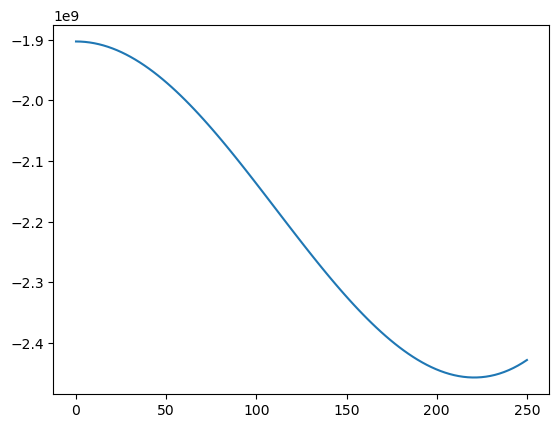

In [6]:
Δ_lin = np.linspace(0, 250, 100)
Ω_tot_list = [Ω_tot([0,Δi], 400, 60) for Δi in Δ_lin]
plt.plot(Δ_lin, Ω_tot_list)

In [7]:
def finding_minima(μ, T):
        init_guess = [150, 500]
        result = optimize.minimize(Ω_tot, init_guess,method="Powell" ,args=(μ, T), bounds=((0,300),(0,1000)))
        minima = result.x
        #minima = np.append(minima, μ)
        #print(minima)
        return minima

def finding_minima_new(μ, T):
        ϕ_lin = np.linspace(0,310,100)
        Δ_lin = np.linspace(0,300,100)
        Ω_ϕ = [Ω_tot([ϕi, 0], μ, T) for ϕi in ϕ_lin]
        Ω_Δ = [Ω_tot([0, Δi], μ, T) for Δi in Δ_lin]
        
        Ω_min_ϕ = np.min(Ω_ϕ)
        Ω_min_Δ = np.min(Ω_Δ)
        
        ϕ0 = ϕ_lin[np.where(Ω_ϕ == Ω_min_ϕ)][0]
        Δ0 = Δ_lin[np.where(Ω_Δ == Ω_min_Δ)][0]
        #print(ϕ0, Δ0)
        if Ω_min_ϕ < Ω_min_Δ:
            init_guess = [ϕ0, 0]
            result = optimize.minimize(Ω_tot, init_guess,method="Powell", args=(μ,T), bounds=((0,300),(0,100)))
            minima = result.x
            #minima = np.append(minima, μ)
            #print(minima)
            return minima
        else:
            init_guess = [0, Δ0]
            result = optimize.minimize(Ω_tot, init_guess,method="Powell", args=(μ,T), bounds=((0,100),(0,500)))
            minima = result.x
            #minima = np.append(minima, μ)
            #print(minima)
            return minima

In [8]:
def Newtons_method_for_PT_ϕ1(T, μ_bound):
    
    #minima_μ_min = finding_minima_new(μ_bound[0], T)
    #minima_μ_max = finding_minima_new(μ_bound[1], T)
    
    μ_min, μ_max = μ_bound
    
    #minima_ϕ_vac, minima_Δ_vac = finding_minima(0, 1)
    
    while μ_max-μ_min > 0.1:
        μ_test = (μ_min+μ_max)/2
        minima_ϕ_μ_test, minima_Δ_μ_test = finding_minima_new(μ_test, T)
        #print("minima is ", minima_ϕ_μ_test)
        if minima_ϕ_μ_test < 1:
            μ_max = μ_test
        else:
            μ_min = μ_test
        #print("μ range is ", μ_min, " - ", μ_max)
    return (μ_max+μ_min)/2

def Newtons_method_for_PT_Δ1(T, μ_bound):
    
    #minima_μ_min = finding_minima_new(μ_bound[0], T)
    #minima_μ_max = finding_minima_new(μ_bound[1], T)
    
    μ_min, μ_max = μ_bound
    
    #minima_ϕ_vac, minima_Δ_vac = finding_minima(0, 1)
    
    while μ_max-μ_min > 0.1:
        μ_test = (μ_min+μ_max)/2
        minima_ϕ_μ_test, minima_Δ_μ_test = finding_minima_new(μ_test, T)
        #print("minima is ", minima_Δ_μ_test)
        if minima_Δ_μ_test > 1:
            μ_max = μ_test
        else:
            μ_min = μ_test
        #print("μ range is ", μ_min, " - ", μ_max)
    return (μ_max+μ_min)/2

In [9]:
T_lin1_set1 = np.linspace(1, 79.5, 10)
T_lin2_set1 = np.linspace(79.5, 153, 20)

λ3 = λ0
λΔ = λ0/4
mΔ = 500
gΔ = 2*g0

PT_ϕΔ_equal_list1 = [Newtons_method_for_PT_ϕ1(Ti, [200, 400]) for Ti in tqdm(T_lin1_set1)]
PT_ϕ_list1 = [Newtons_method_for_PT_ϕ1(Ti, [0, 350]) for Ti in tqdm(T_lin2_set1)]
PT_Δ_list1 = [Newtons_method_for_PT_Δ1(Ti, [200, 600]) for Ti in tqdm(T_lin2_set1)]

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\mathi\AppData\Local\Temp\ipykernel_22216\751183956.py:23: OptimizeWarning: Initial guess is not within the specified bounds
  result = optimize.minimize(Ω_tot, init_guess,method="Powell", args=(μ,T), bounds=((0,300),(0,100)))
C:\Users\mathi\AppData\Local\Temp\ipykernel_22216\1475276626.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff, limit=150)
C:\Users\mathi\AppData\Local\Temp\ipykernel_22216\1475276626.py:34: IntegrationWarning: The maximum number of subdivisions (150) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval a

In [10]:
print(PT_ϕΔ_equal_list1)
print(PT_Δ_list1)

[250.244140625, 249.951171875, 249.072265625, 247.900390625, 246.435546875, 244.677734375, 242.431640625, 239.794921875, 236.572265625, 232.763671875]
[233.642578125, 244.677734375, 256.591796875, 269.287109375, 283.056640625, 297.900390625, 314.013671875, 331.591796875, 351.025390625, 372.412109375, 396.240234375, 423.095703125, 453.662109375, 489.013671875, 530.712890625, 581.103515625, 599.951171875, 599.951171875, 599.951171875, 599.951171875]


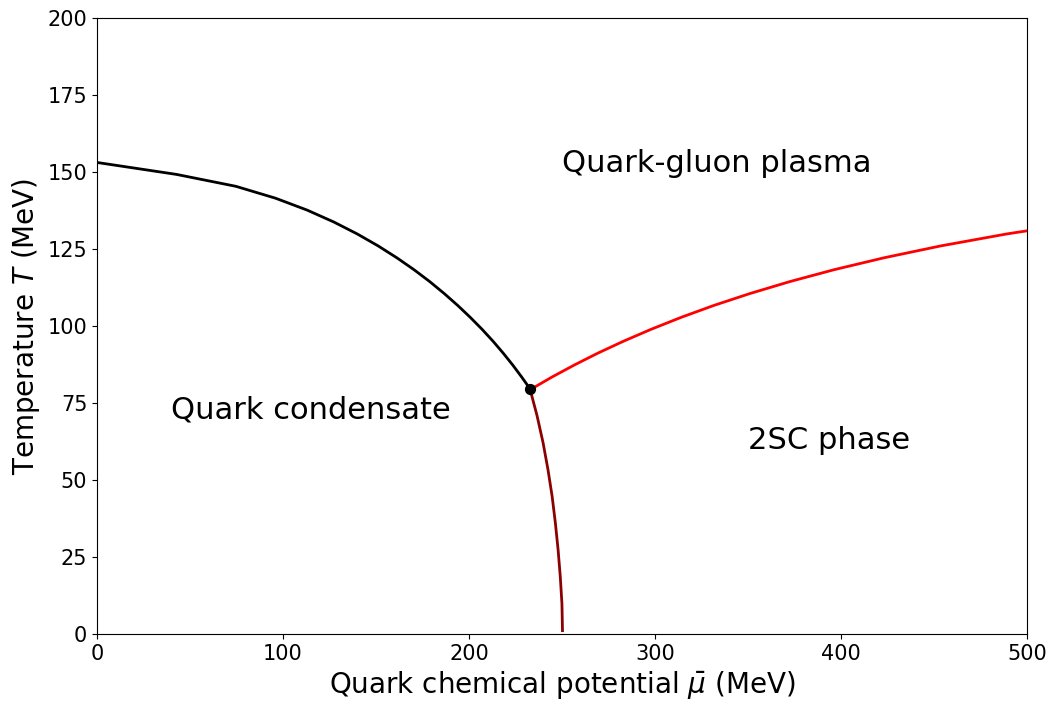

In [11]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(12,8))

plt.plot(PT_ϕΔ_equal_list1, T_lin1_set1, c= "darkred", linewidth=2,zorder=1)
plt.plot(PT_ϕ_list1, T_lin2_set1, c= "black", linewidth=2,zorder=2)
plt.plot(PT_Δ_list1, T_lin2_set1, c= "red", linewidth=2, zorder=3)
plt.scatter(233, 79.5, c= "black",s=50, zorder=4)

#plt.title(r"$\bar{\phi}_0$" + " and " + r"$\bar{\Delta}_0$" + " in " + r"$\mu-T$" + " plane for parameter set 1", fontsize=22)
plt.xlabel("Quark chemical potential "+r"$\bar{\mu}$" + " (MeV)", fontsize=20)
plt.ylabel("Temperature " + r"$T$" + " (MeV)", fontsize=20)

plt.text(40,70,"Quark condensate", fontsize=22)
plt.text(250,150,"Quark-gluon plasma", fontsize=22)
plt.text(350,60,"2SC phase", fontsize=22)

plt.xlim(0,500)
plt.ylim(0,200)
plt.savefig("PhaseDiagramSet1.pdf")
plt.show()

In [12]:
T_lin1_set2 = np.linspace(1, 77, 10)
T_lin2_set2 = np.linspace(77, 153, 20)
T_lin3_set2 = np.linspace(77, 180, 20)
λ3 = λ0
λΔ = λ0/4
mΔ = 500
gΔ = 3/2*g0

PT_ϕΔ_equal_list2 = [Newtons_method_for_PT_ϕ1(Ti, [200, 400]) for Ti in tqdm(T_lin1_set2)]
PT_ϕ_list2 = [Newtons_method_for_PT_ϕ1(Ti, [0, 350]) for Ti in tqdm(T_lin2_set2)]
PT_Δ_list2 = [Newtons_method_for_PT_Δ1(Ti, [200, 600]) for Ti in tqdm(T_lin3_set2)]

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\mathi\AppData\Local\Temp\ipykernel_22216\751183956.py:23: OptimizeWarning: Initial guess is not within the specified bounds
  result = optimize.minimize(Ω_tot, init_guess,method="Powell", args=(μ,T), bounds=((0,300),(0,100)))
C:\Users\mathi\AppData\Local\Temp\ipykernel_22216\1475276626.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff, limit=150)
C:\Users\mathi\AppData\Local\Temp\ipykernel_22216\1475276626.py:34: IntegrationWarning: The maximum number of subdivisions (150) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval a

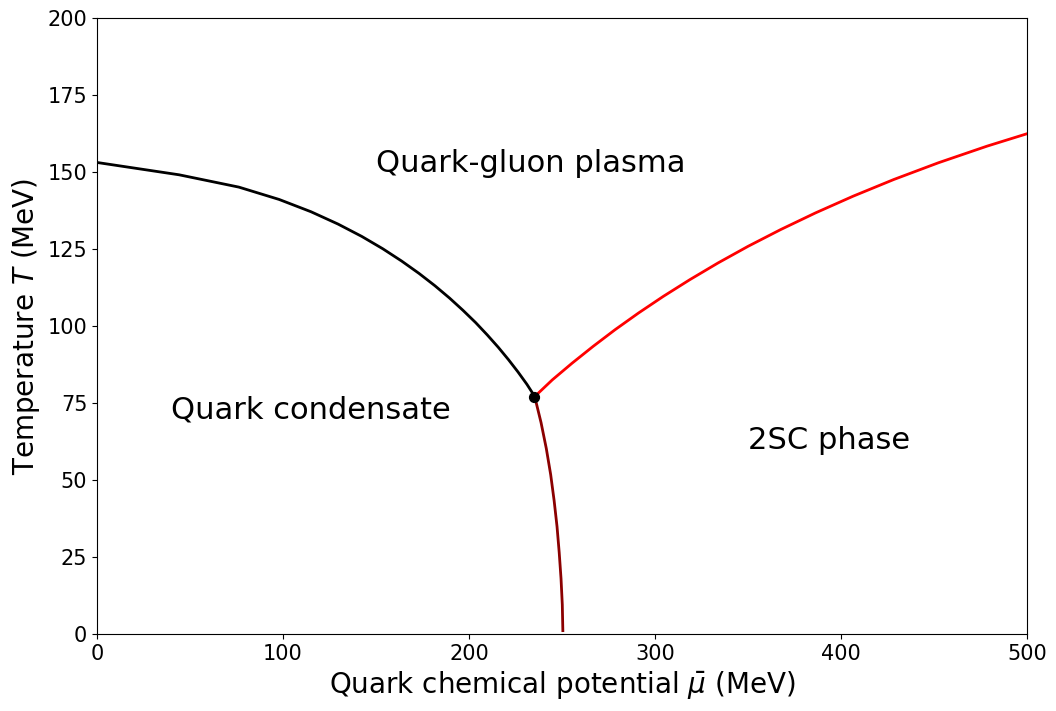

In [13]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(12,8))

plt.plot(PT_ϕΔ_equal_list2, T_lin1_set2, c= "darkred", linewidth=2, zorder=1)
plt.plot(PT_ϕ_list2, T_lin2_set2, c= "black", linewidth=2, zorder=2)
plt.plot(PT_Δ_list2, T_lin3_set2, c= "red", linewidth=2, zorder=3)
#plt.scatter(PT_ϕ_list1, T_lin2, c= "black")
#plt.scatter(PT_Δ_list1, T_lin2, c= "red")
plt.scatter(235, 77, c= "black",s=50, zorder=4)

#plt.title(r"$\bar{\phi}_0$" + " and " + r"$\bar{\Delta}_0$" + " in " + r"$\mu-T$" + " plane for parameter set 2", fontsize=22)
plt.xlabel("Quark chemical potential "+r"$\bar{\mu}$" + " (MeV)", fontsize=20)
plt.ylabel("Temperature " + r"$T$" + " (MeV)", fontsize=20)

plt.text(40,70,"Quark condensate", fontsize=22)
plt.text(150,150,"Quark-gluon plasma", fontsize=22)
plt.text(350,60,"2SC phase", fontsize=22)

plt.xlim(0,500)
plt.ylim(0,200)
plt.savefig("PhaseDiagramSet2.pdf")
plt.show()

In [14]:
T_lin1_set3 = np.linspace(1, 69.5, 10)
T_lin2_set3 = np.linspace(69.5, 153, 20)

λ3 = λ0
λΔ = λ0/4
mΔ = 600
gΔ = 2*g0

PT_ϕΔ_equal_list3 = [Newtons_method_for_PT_ϕ1(Ti, [200, 400]) for Ti in tqdm(T_lin1_set3)]
PT_ϕ_list3 = [Newtons_method_for_PT_ϕ1(Ti, [0, 350]) for Ti in tqdm(T_lin2_set3)]
PT_Δ_list3 = [Newtons_method_for_PT_Δ1(Ti, [200, 600]) for Ti in tqdm(T_lin2_set3)]

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\mathi\AppData\Local\Temp\ipykernel_22216\751183956.py:23: OptimizeWarning: Initial guess is not within the specified bounds
  result = optimize.minimize(Ω_tot, init_guess,method="Powell", args=(μ,T), bounds=((0,300),(0,100)))
C:\Users\mathi\AppData\Local\Temp\ipykernel_22216\1475276626.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff, limit=150)
C:\Users\mathi\AppData\Local\Temp\ipykernel_22216\1475276626.py:34: IntegrationWarning: The maximum number of subdivisions (150) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval a

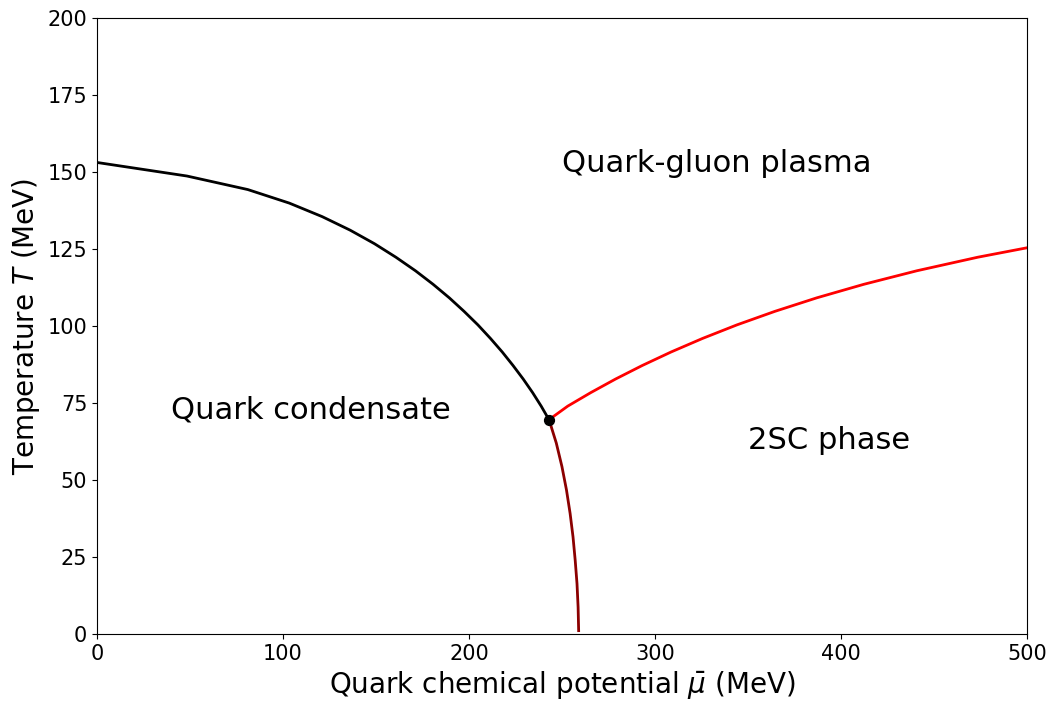

In [15]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(12,8))
plt.plot(PT_ϕΔ_equal_list3, T_lin1_set3, c= "darkred", linewidth=2)
plt.plot(PT_ϕ_list3, T_lin2_set3, c= "black", linewidth=2)
plt.plot(PT_Δ_list3, T_lin2_set3, c= "red", linewidth=2)
#plt.scatter(PT_ϕ_list3, T_lin2_set3, c= "black")
#plt.scatter(PT_Δ_list3, T_lin2_set3, c= "red")

plt.scatter(243, 69.5, c= "black",s=50, zorder=4)

#plt.title(r"$\bar{\phi}_0$" + " and " + r"$\bar{\Delta}_0$" + " in " + r"$\mu-T$" + " plane for parameter set 3")
plt.xlabel("Quark chemical potential "+r"$\bar{\mu}$" + " (MeV)",fontsize=20)
plt.ylabel("Temperature " + r"$T$" + " (MeV)", fontsize=20)

plt.text(40,70,"Quark condensate", fontsize=22)
plt.text(250,150,"Quark-gluon plasma", fontsize=22)
plt.text(350,60,"2SC phase", fontsize=22)

plt.xlim(0,500)
plt.ylim(0,200)
plt.savefig("PhaseDiagramSet3.pdf")
plt.show()

In [16]:
T_lin1_set4 = np.linspace(1, 63, 10)
T_lin2_set4 = np.linspace(63, 153, 20)
T_lin3_set4 = np.linspace(63, 160, 20)

λ3 = λ0
λΔ = λ0/4
mΔ = 600
gΔ = 3/2*g0

PT_ϕΔ_equal_list4 = [Newtons_method_for_PT_ϕ1(Ti, [200, 400]) for Ti in tqdm(T_lin1_set4)]
PT_ϕ_list4 = [Newtons_method_for_PT_ϕ1(Ti, [0, 350]) for Ti in tqdm(T_lin2_set4)]
PT_Δ_list4 = [Newtons_method_for_PT_Δ1(Ti, [200, 600]) for Ti in tqdm(T_lin3_set4)]

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\mathi\AppData\Local\Temp\ipykernel_22216\751183956.py:23: OptimizeWarning: Initial guess is not within the specified bounds
  result = optimize.minimize(Ω_tot, init_guess,method="Powell", args=(μ,T), bounds=((0,300),(0,100)))
C:\Users\mathi\AppData\Local\Temp\ipykernel_22216\1475276626.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, err = integrate.quad(integrand, 0, Λ_cutoff, limit=150)
C:\Users\mathi\AppData\Local\Temp\ipykernel_22216\1475276626.py:34: IntegrationWarning: The maximum number of subdivisions (150) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval a

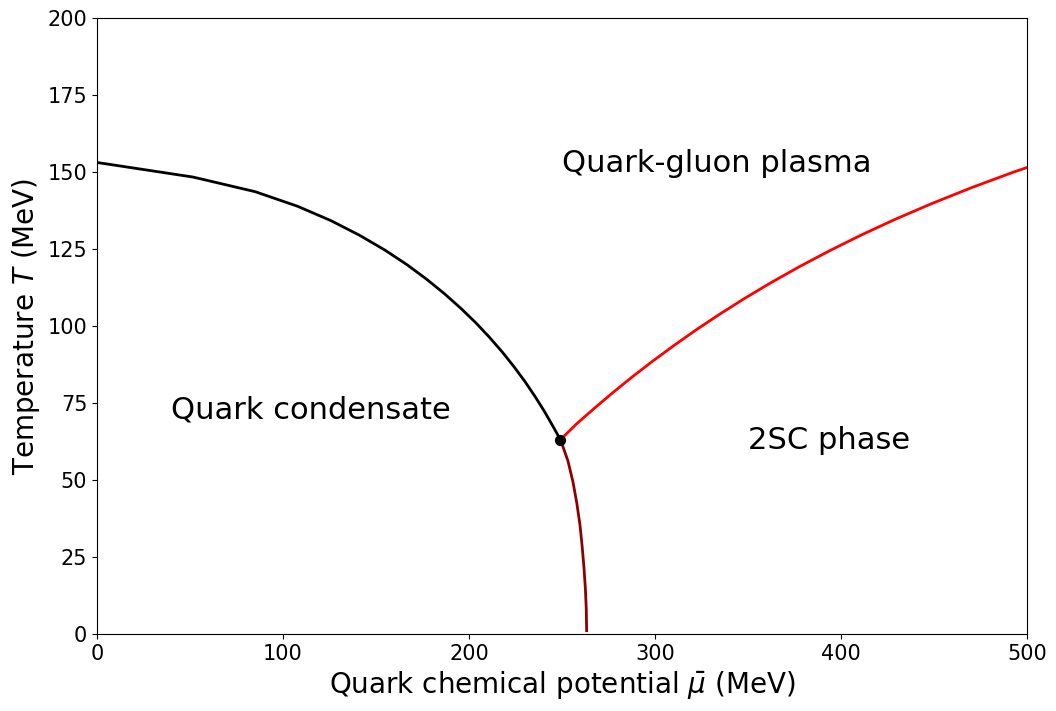

In [17]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(12,8))
plt.plot(PT_ϕΔ_equal_list4, T_lin1_set4, c= "darkred", linewidth=2, zorder=1)
plt.plot(PT_ϕ_list4, T_lin2_set4, c= "black", linewidth=2, zorder=2)
plt.plot(PT_Δ_list4, T_lin3_set4, c= "red", linewidth=2,zorder=3)
#plt.scatter(PT_ϕ_list4, T_lin2_set4, c= "black")
#plt.scatter(PT_Δ_list4, T_lin3_set4, c= "red")
#plt.title(r"$\bar{\phi}_0$" + " and " + r"$\bar{\Delta}_0$" + " in " + r"$\mu-T$" + " plane for parameter set 4")
plt.xlabel("Quark chemical potential "+r"$\bar{\mu}$" + " (MeV)", fontsize=20)
plt.ylabel("Temperature " + r"$T$" + " (MeV)", fontsize=20)

plt.scatter(249, 63, c= "black", s=50, zorder=4)

plt.text(40,70,"Quark condensate", fontsize=22)
plt.text(250,150,"Quark-gluon plasma", fontsize=22)
plt.text(350,60,"2SC phase", fontsize=22)

plt.xlim(0,500)
plt.ylim(0,200)
plt.savefig("PhaseDiagramSet4.pdf")
plt.show()